# Tikhonov Regularization Tutorial: Seattle-Tacoma Housing Data

**Intro**

This tutorial shows how to use variable $L_2$ regularization with glum. The `P2` parameter of the `GeneralizedLinearRegressor` class allows you to directly set the $L_2$ penalty matrix $w^T P_2 w$. If a 2d array is passed for the `P2` parameter, it is used directly, while if you pass a 1d array as `P2` it will be interpreted as the diagonal of $P_2$ and all other entries will be assumed to be zero.

*Note*: Variable $L_1$ regularization is also available by passing an array with length `n_features` to the `P1` parameter. 


**Background**

For this tutorial, we will model the selling price of homes in King's County, Washington (Seattle-Tacoma Metro area) between May 2014 and May 2015. However, in order to demonstrate a Tikhonov regularization-based spatial smoothing technique, we will focus on a small, skewed data sample from that region in our training data. Specifically, we will show that when we have (a) a fixed effect for each postal code region and (b) only a select number of training observations in a certain region, we can improve the predictive power of our model by regularizing the difference between the coefficients of neighboring regions. While we are constructing a somewhat artificial example here in order to demonstrate the spatial smoothing technique, we have found similar techniques to be applicable to real-world problems. 

We will use a gamma distribution for our model. This choice is motivated by two main factors. First, our target variable, home price, is a positive real number, which matches the support of the gamma distribution. Second, it is expected that factors influencing housing prices are multiplicative rather than additive, which is better captured with a gamma regression than say, OLS.


*Note*: a few parts of this tutorial utilize local helper functions outside this notebook. If you wish to run the notebook on your own, you can find the rest of the code [here](https://github.com/Quantco/glum/tree/open-sourcing/docs/tutorials/regularization_housing_data).


## Table of Contents<a class="anchor"></a>
* [1. Load and Prepare Datasets from Openml.org](#1.-Load-and-Prepare-Datasets-from-Openml-Data)
* [2. Visualize Geographic Data with GIS Open Data](#2.-Visualize-Geographic-Data-with-GIS-Open-Data)
* [3. Feature Selection and Transformation](#3.-Feature-Selection-and-Transformation)
* [4. Create P matrix](#4.-Create-P-Matrix)
* [5. Fit Models](#5.-Fit-Models)

In [1]:
import itertools

import geopandas as geopd
import libpysal
import matplotlib.pyplot as plt
import numpy as np
import openml
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from glum import GeneralizedLinearRegressor

import sys
sys.path.append("../")
from metrics import root_mean_squared_percentage_error

import warnings
warnings.filterwarnings("ignore", message="The weights matrix is not fully connected")

import data_prep
import maps

## 1. Load and prepare datasets from Openml<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

### 1.1. Download and transform
The main dataset is downloaded from OpenML. You can find the main page for the dataset [here](https://www.openml.org/d/42092). It is also available through Kaggle [here](https://www.kaggle.com/harlfoxem/housesalesprediction). 

As part of data preparation, we also do some transformations to the data:

- We remove some outliers (homes over 1.5 million and under 100k). 
- Since we want to focus on geographic features, we also remove a handful of the other features.

Below, you can see some example rows from the dataset.

In [2]:
df = data_prep.download_and_transform()
df.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,zipcode,price
0,3,1.00,1180,1.0,0,0,3,0,1955,98178,221900.0
1,3,2.25,2570,2.0,0,0,3,400,1951,98125,538000.0
2,2,1.00,770,1.0,0,0,3,0,1933,98028,180000.0
3,4,3.00,1960,1.0,0,0,5,910,1965,98136,604000.0
4,3,2.00,1680,1.0,0,0,3,0,1987,98074,510000.0


## 2. Visualize geographic data with GIS open<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

To help visualize the geographic data, we use geopandas and GIS Open Data to display price information on the King's county map. You can get the map data [here]("https://gis-kingcounty.opendata.arcgis.com/datasets/all-zipcodes-and-po-box-as-centroids-for-king-county-zipcode-all-point/data?geometry=-126.017%2C46.845%2C-116.788%2C48.144&page=2"). 

To show the relatioship between home price and geography, we merge the map data with our sales data and use a heat map to plot mean home sale price for each postal code region.

In [3]:
maps.read_shapefile("Zip_Codes/Zip_Codes.shp")

,OBJECTID,ZIP,ZIPCODE,COUNTY,SHAPE_Leng,SHAPE_Area,geometry
0,1,98031,98031,033,117508.211718,2.280129e+08,"POLYGON ((-122.2184228967409 47.4375036485968,..."
1,2,98032,98032,033,166737.664791,4.826754e+08,(POLYGON ((-122.2418694980486 47.4412158004961...
2,3,98033,98033,033,101363.840369,2.566747e+08,POLYGON ((-122.2057111926017 47.65169738162997...
3,4,98034,98034,033,98550.452509,2.725072e+08,POLYGON ((-122.1755100327681 47.73706057280546...
4,5,98030,98030,033,94351.264837,2.000954e+08,POLYGON ((-122.1674637459728 47.38548925033355...
...,...,...,...,...,...,...,...
199,200,98402,98402,053,30734.178112,2.612224e+07,"POLYGON ((-122.4427945843513 47.2647926142345,..."
200,201,98403,98403,053,23495.038425,2.890938e+07,POLYGON ((-122.4438167281511 47.26617469660845...
201,202,98404,98404,053,61572.154365,2.160645e+08,POLYGON ((-122.3889999141967 47.23495303304902...
202,203,98405,98405,053,50261.100559,1.193118e+08,POLYGON ((-122.4409198889526 47.23639133730699...


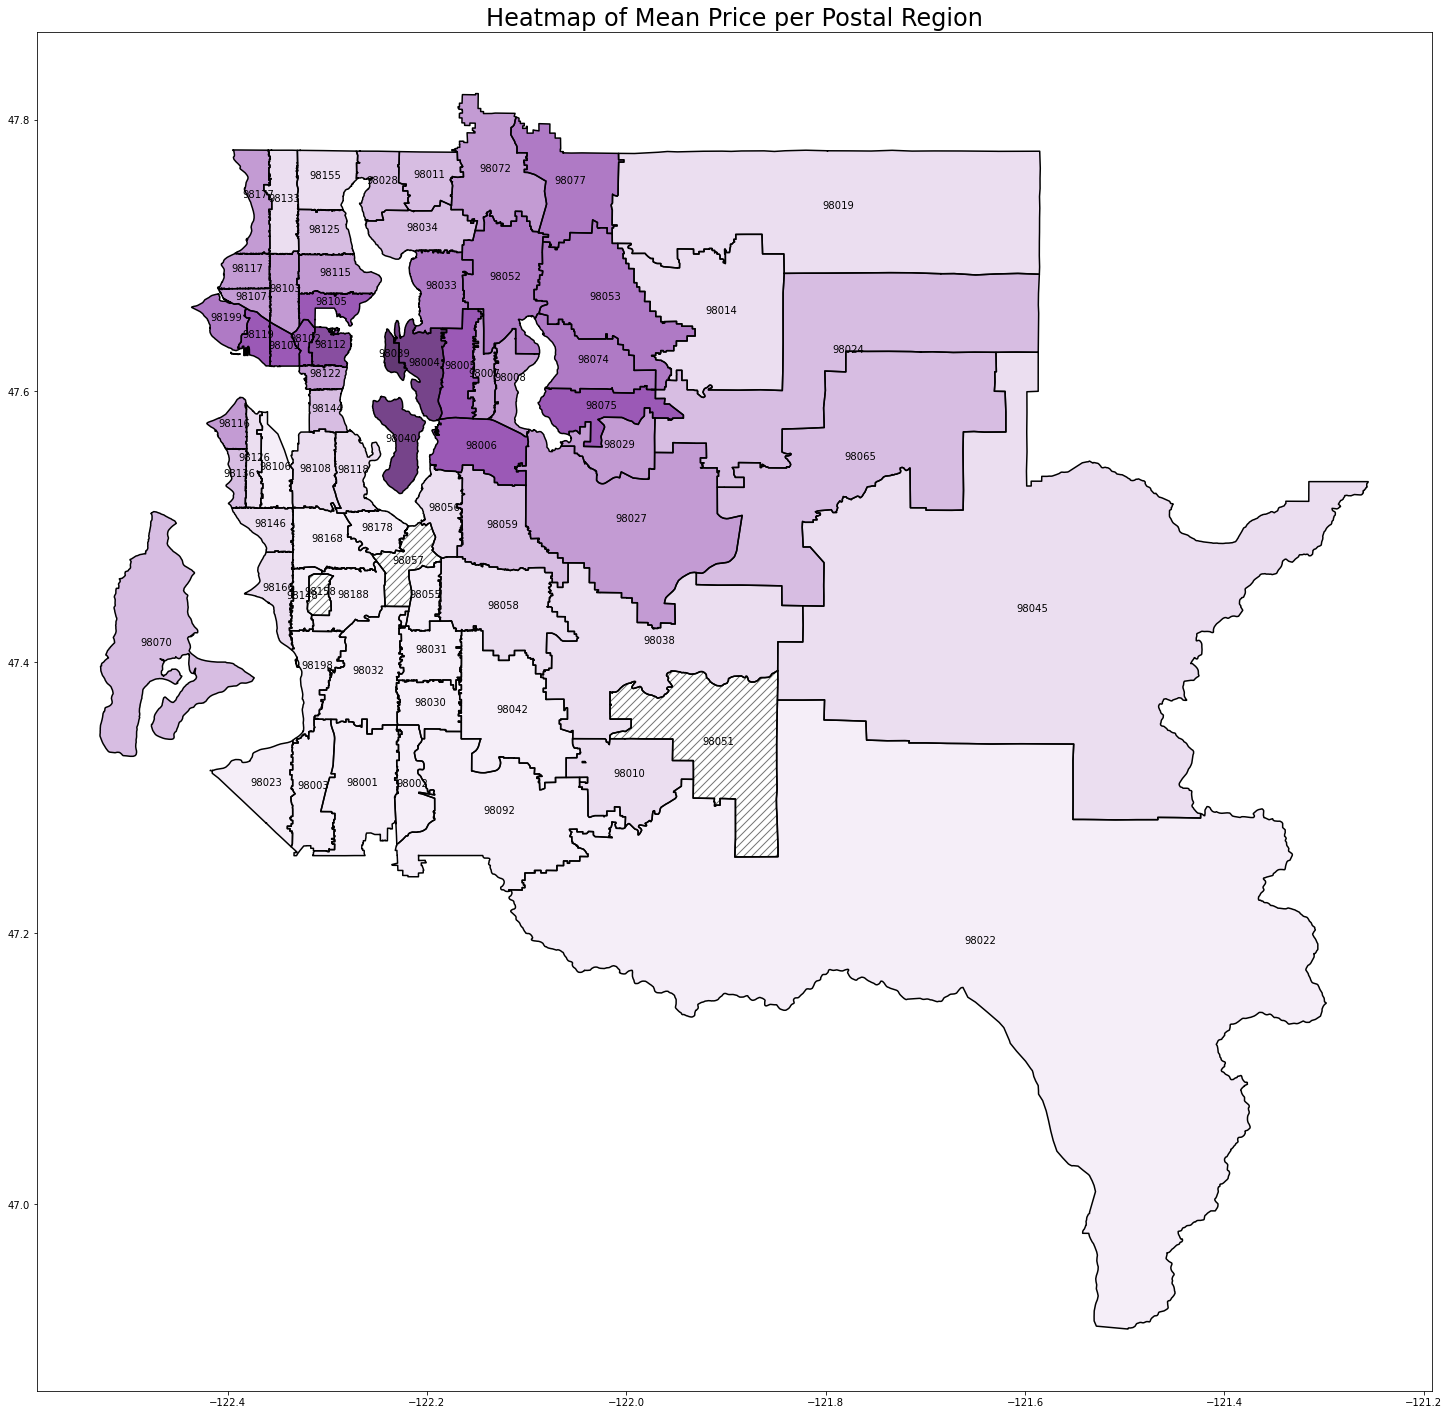

In [4]:
df_shapefile = maps.read_shapefile("Zip_Codes/Zip_Codes.shp")
df_map = maps.create_kings_county_map_df(df, df_shapefile)

fix, ax = plt.subplots(figsize=(25, 25))
maps.plot_heatmap(df=df_map, label_col="ZIP", data_col="price", ax=ax)
ax.set_title("Heatmap of Mean Price per Postal Region", fontsize=24)
plt.show()

We can see a clear relationship between postal code and home price. Seattle (98112, 98102, etc.) and the Bellevue/Mercer/Medina suburbs (98039, 98004, 98040) have the highest prices. As you get further from the city, the prices start to drop.

## 3. Feature selection and transformation<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)


### 3.1 Feature selection and one hot encoding
Since we want to focus on geographic data, we drop a number of columns below. We keep a handful of columns so that we can still create a reasonable model. 

We then create a fixed effect for each of the postal code regions. We add the encoded postcode columns in numeric order to help us maintain the proper order of columns while building and training the model. 

In [5]:
sorted_zips = sorted(list(df["zipcode"].unique()))
one_hot = pd.get_dummies(df["zipcode"], dtype=float)
one_hot = one_hot[sorted_zips]
df = df.drop('zipcode', axis=1)
df = one_hot.join(df)
df.head()

,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,...,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,price
0,0,0,0,0,0,0,0,0,0,0,...,3,1.00,1180,1.0,0,0,3,0,1955,221900.0
1,0,0,0,0,0,0,0,0,0,0,...,3,2.25,2570,2.0,0,0,3,400,1951,538000.0
2,0,0,0,0,0,0,0,0,0,0,...,2,1.00,770,1.0,0,0,3,0,1933,180000.0
3,0,0,0,0,0,0,0,0,0,0,...,4,3.00,1960,1.0,0,0,5,910,1965,604000.0
4,0,0,0,0,0,0,0,0,0,0,...,3,2.00,1680,1.0,0,0,3,0,1987,510000.0


### 3.2 Test train split
As we mentioned in the introduction, we want to focus on modeling the selling price in a specific region while only using a very small, skewed data sample from that region in our training data. This scenario could arise if say, our task was to predict the sales prices for homes in Enumclaw (large region with zip code 98022 in the southeast corner of the map), but the only data we had from there was from a small luxury realtor.

To mimic this, instead creating a random split between our training and test data, we will intentionally create a highly skewed sample. For our test set, we will take all of the home sales in Enumclaw, *except* for the 15 highest priced homes. 

Finally, we standardize our predictors.

In [6]:
predictors = [c for c in df.columns if c != "price"]

test_region = "98022"
df_train = df[df[test_region] == 0]
df_test = df[df[test_region] == 1].sort_values(by="price", ascending=False)

test_to_train = df_test[:15]

df_train = pd.concat([df_train, test_to_train])
df_test = df_test.drop(test_to_train.index)

X_train = df_train[predictors]
y_train = df_train["price"]
X_test = df_test[predictors]
y_test = df_test["price"]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 4. Creating the penalty matrix<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

To smooth the coefficients for neighboring regions, we will create a penalty matrix $P$ such that we penalize the squared difference in coefficient values for neighbouring regions, e.g. for 98022 and 98045. For example, if 98022 and 98045 were the only region in question, we would need a $2 \times 2$ matrix $P$ such that:
$$\begin{pmatrix} \beta_{98022}, \beta_{98045}\end{pmatrix} P \begin{pmatrix} \beta_{98022} \\ \beta_{98045}\end{pmatrix}
= (\beta_{98022} - \beta_{98045})^2$$

In this example, we would get this result with $P = \begin{pmatrix} 1 & -1 \\ -1 & 1\end{pmatrix}$. 

Since we have 72 postal code regions, it would be rather annoying to construct this matrix by hand. Luckily, there are libraries that exist for this. We use [pysal](http://pysal.org)'s [pysal.lib.weights.Queen](https://pysal.org/libpysal/generated/libpysal.weights.Queen.html) to retrieve a neighbor's matrix from our map data. The construction of the penalty matrix is rather straightforward once we have this information.

We leave the non-geographic features unregularized (all zeros in the $P$ matrix).

In [7]:
# format is {zip1: {neighbord1: 1, neighbor2: 1, ...}}
neighbor_matrix = libpysal.weights.Queen.from_dataframe(df_map, ids="ZIP") 

n_features = X_train.shape[1]
P2 = np.zeros((n_features, n_features))

zip2index = dict(zip(sorted_zips, range(len(sorted_zips))))
for zip1 in sorted_zips:
    for zip2 in neighbor_matrix[zip1].keys():
        if zip1 in zip2index and zip2 in zip2index: # ignore regions w/o data 
            if zip2index[zip1] < zip2index[zip2]: # don't repeat if already saw neighbor pair in earlier iteration
                P2[zip2index[zip1], zip2index[zip1]] += 1
                P2[zip2index[zip2], zip2index[zip2]] += 1
                P2[zip2index[zip1], zip2index[zip2]] -= 1
                P2[zip2index[zip2], zip2index[zip1]] -= 1
P2

array([[ 3., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  4.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## 5. Fit models<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

Now, we will fit several L2 regularized OLS models using different levels of regularization. All will use the penalty matrix defined above, but the alpha parameter, the constant that multiplies the penalty terms and thus determines the regularization strength, will vary. 

For each model, we will measure test performance using root mean squared percentage error (RMSPE), so that we can get a relaitve result. We will also plot a heatmat of the coefficient values over the regions.

*Note*: alpha=1e-12 is effectively no regularization. But we can't set alpha to zero because the unregularized problem has co-linear columns, resulting in a singular design matrix. 

alpha=1e-12
Test region coefficient: 0.0010920106922960072
Test RMSPE: 72.65620542354644

alpha=0.1
Test region coefficient: -0.0036087215513505183
Test RMSPE: 43.926082004444204

alpha=1
Test region coefficient: -0.01041392075707663
Test RMSPE: 19.51113178158937

alpha=10
Test region coefficient: -0.0033476740903954213
Test RMSPE: 44.59786775358339



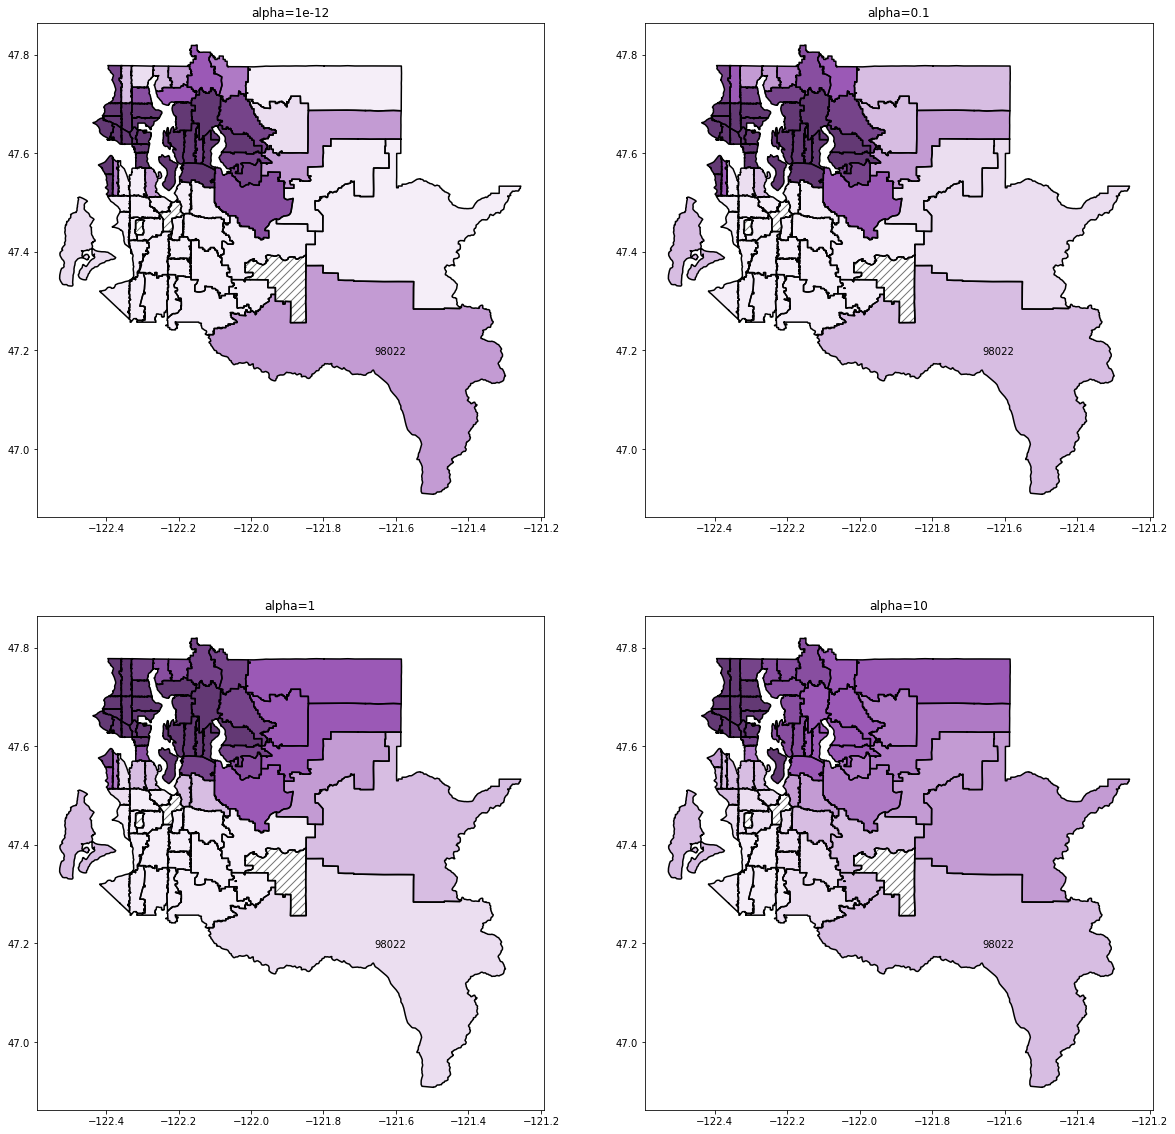

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
for i, alpha in enumerate([1e-12, 1e-1, 1, 10]):
    
    glm = GeneralizedLinearRegressor(family='gamma', alpha=alpha, P2=P2, fit_intercept=True)
    glm.fit(X_train, y_train)
    y_test_hat = glm.predict(X_test)
    
    coeffs = pd.DataFrame({'coefficient': np.concatenate(([glm.intercept_], glm.coef_))}, ["intercept"]+predictors)
    
    print(f"alpha={alpha}")
    print(f"Test region coefficient: {coeffs.loc[test_region].values[0]}")
    print(f"Test RMSPE: {root_mean_squared_percentage_error(y_test_hat, y_test)}\n")
    
    df_map_coeffs = df_map.merge(
        coeffs.loc[sorted_zips],
        left_on="ZIP",
        right_index=True,
        how="outer"
    )
    
    ax = axs[i//2, i%2]
    df_map_coeffs["annotation"] = df_map_coeffs["ZIP"].apply(lambda x: "" if x!=test_region else x)
    maps.plot_heatmap(
        df=df_map_coeffs,
        label_col="annotation",
        data_col="coefficient",
        ax=ax,
        vmin=-0.015,
        vmax=0.025
    )
    ax.set_title(f"alpha={alpha}")
          
plt.show()

alpha=1 seems to recover the best results. Remember that our test dataset is just a small subset of the data in region 98022 and that the training data is skewed towards high sales prices. For alpha less than 1, we can see that the 98022 region coefficient is still much greater than its neighbors coefficients, which we can see is not accurate if we refer back to map we produced based on the raw data. For higher alpha levels, we start to see poor predictions resulting from regional coefficients that are too smooth between adjacent regions.

A test RMSPE of 19.5% is a surprisingly good result considering that we only had 10 highly skewed observations from our test region in our training data and is far better than the RMSPE of 67.5% from the unregularized case.